Name : Iklima Mardiana

Email : iklimardiana911@gmail.com

Dataset : https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection

**Mount Google Drive**

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**import**

In [43]:
import shutil
import os
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback

**Copy zip file to colab**

In [35]:
zip_file_path = '/content/drive/MyDrive/dataset/archive.zip'
colab_zip_path = '/content/archive.zip'
shutil.copy(zip_file_path, colab_zip_path)

'/content/archive.zip'

**Extract dataset**

In [36]:
with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

**Directory**

In [37]:
data_dir = '/content/Dataset'
data_dir

'/content/Dataset'

In [38]:
os.listdir(data_dir)

['with_mask', 'mask_weared_incorrect', 'without_mask']

**Calculate and display image distribution before deletion.**

In [39]:
image_count = len(list(pathlib.Path(data_dir).glob('*/*.jpg')))
print(f'Total images in the dataset: {image_count}')

print('\nImage Distribution:')
for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')

Total images in the dataset: 0

Image Distribution:
1. with_mask : 2994
2. mask_weared_incorrect : 2994
3. without_mask : 2994


**Augmentation and load data**

In [44]:
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

**Flow From Directory**

In [45]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


**Model**

In [46]:
model = tf.keras.models.Sequential([
    VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


58889256/58889256 [==============================] - 4s 0us/step


In [47]:
# Display the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 512)               33280     
                                                      

**Compile the model**

In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

**Callback to stop training when both training and validation accuracy reach 90%**

In [52]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, min_epochs=10):
    self.min_epochs = min_epochs
    self.epochs_passed = 0

  def on_epoch_end(self, epoch, logs={}):
    self.epochs_passed += 1

    if self.epochs_passed >= self.min_epochs and logs.get('accuracy') > 0.9:
      print(f"Training stopped as both training and validation accuracy reached 90% after {self.epochs_passed} epochs")
      self.model.stop_training = True

callbacks = myCallback()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

**Train the model**

In [53]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=5,
    verbose=2,
    callbacks=[callbacks, early_stopping]
)

Epoch 1/100
113/113 - 73s - loss: 0.0612 - accuracy: 0.9794 - val_loss: 0.1121 - val_accuracy: 0.9625 - 73s/epoch - 646ms/step
Epoch 2/100
113/113 - 69s - loss: 0.0437 - accuracy: 0.9880 - val_loss: 0.1729 - val_accuracy: 0.9750 - 69s/epoch - 608ms/step
Epoch 3/100
113/113 - 72s - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.0443 - val_accuracy: 0.9906 - 72s/epoch - 640ms/step
Epoch 4/100
113/113 - 69s - loss: 0.0252 - accuracy: 0.9910 - val_loss: 0.0769 - val_accuracy: 0.9875 - 69s/epoch - 610ms/step
Epoch 5/100
113/113 - 69s - loss: 0.0303 - accuracy: 0.9910 - val_loss: 0.1190 - val_accuracy: 0.9781 - 69s/epoch - 607ms/step
Epoch 6/100
113/113 - 67s - loss: 0.0269 - accuracy: 0.9905 - val_loss: 0.0569 - val_accuracy: 0.9844 - 67s/epoch - 591ms/step
Epoch 7/100
113/113 - 66s - loss: 0.0226 - accuracy: 0.9936 - val_loss: 0.0766 - val_accuracy: 0.9875 - 66s/epoch - 586ms/step
Epoch 8/100
113/113 - 67s - loss: 0.0341 - accuracy: 0.9912 - val_loss: 0.0179 - val_accuracy: 0.9906 - 67s/epo

In [54]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-54-036bcfb1f050>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


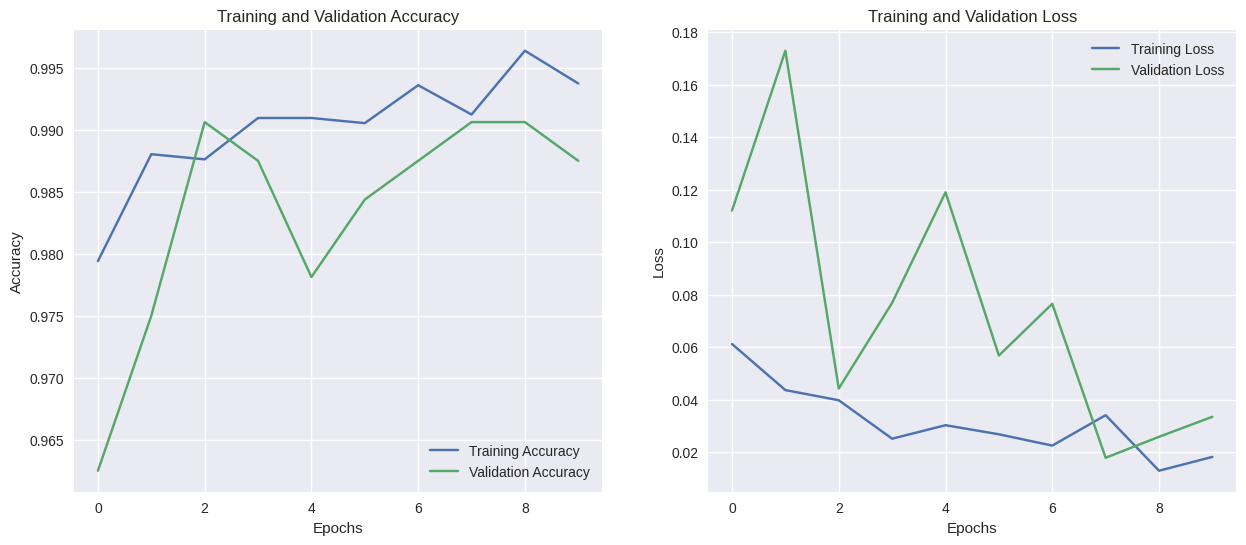

In [55]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Testing Model**

In [56]:
print(train_generator.class_indices)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


Saving 1.png to 1 (3).png
1/1 [==============================] - 0s 26ms/step
1 (3).png
mask_weared_incorrect


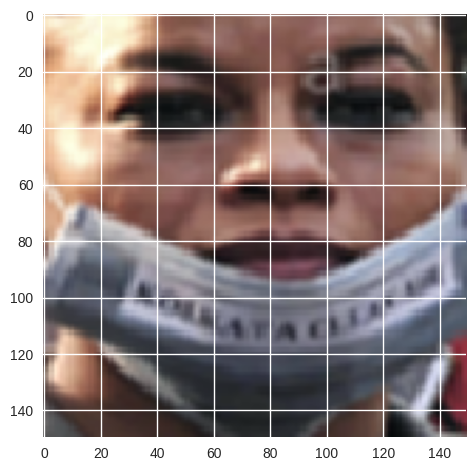

In [62]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150, 150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=32)
  print(fn)
  if classes[0][0]==1:
    print('mask_weared_incorrect')
  elif classes[0][1]==1:
    print('with_mask')
  elif classes[0][2]==1:
    print('without_mask')
  else:
    print('UNKNOWN')


**Save model to SavedModel format**

In [63]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)


**Convert SavedModel to vegs.tflite**

In [64]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

60711908